In [1]:
hydro_output_cdf = '/net/babaracus/home/benr/wqmodels/ssm/unionriver/hyd/1x_1pass/OUTPUT/netcdf/ssm_*.nc'
rivers_cdf = '../input_files/data/fvcom_riv_2014.nc'
extracts_path = '/home/benr/wqmodels/lo/LiveOcean_output/tef/union1x'
#section_names = ['LynchCove','Twanoh']
section_names = ['AdmInlet2','AdmInlet3','HoodCanalEntrance']
#section_names = ['HoodCanalEntrance','Edgewater']
#section_names = ['HoodCanalEntrance']

node_shapefile = '../gis/ssm filled domain nodes.shp'

import os.path as path
from multiprocessing import Pool

from netCDF4 import Dataset, MFDataset
import networkx as nx
import numpy as np
from scipy.interpolate import interp1d
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from fvcom import FvcomGrid

In [2]:
hydro_output = MFDataset(hydro_output_cdf)
hydro_output

<class 'netCDF4._netCDF4.MFDataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: FVCOM Velocity Blockage Test(Updated Block with Kelp June 2013)                 
    institution: School for Marine Science and Technology
    source: FVCOM_2.7
    history: model started at: 17/08/2022   07:51
    references: http://fvcom.smast.umassd.edu
    Conventions: CF-1.0
    dimensions = ('scalar', 'node', 'nele', 'siglay', 'siglev', 'three', 'four', 'obc', 'obc2', 'time')
    variables = ('nprocs', 'partition', 'Initial_Density', 'x', 'y', 'lon', 'lat', 'siglay', 'siglay_shift', 'siglev', 'h', 'nv', 'a1u', 'a2u', 'aw0', 'awx', 'awy', 'time', 'iint', 'u', 'v', 'ww', 'wts', 'uard_obcn', 'xflux_obc', 'dtfa', 'kh', 'zeta', 'salinity', 'temp')
    groups = ()

In [3]:
section_files = {}
section_extractions = {}
for s in section_names:
    f = path.join(extracts_path, 'extractions/' + s + '.nc')
    section_files[s] = f
    section_extractions[s] = Dataset(f)
    display(section_extractions[s])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    gtagex: union1x
    date_string0: 2014.01.01
    date_string1: 2015.01.02
    dimensions(sizes): xi_sect(10), s_z(10), ocean_time(8784), sdir_str(2), xy(2)
    variables(dimensions): float64 ocean_time(ocean_time), float64 salt(ocean_time, s_z, xi_sect), float64 q(ocean_time, s_z, xi_sect), float64 z0(s_z, xi_sect), float64 DA0(s_z, xi_sect), float64 lon(xi_sect), float64 lat(xi_sect), float64 h(xi_sect), int64 ele(xi_sect), float64 zeta(ocean_time, xi_sect), float64 n(xi_sect, xy)
    groups: 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    gtagex: union1x
    date_string0: 2014.01.01
    date_string1: 2015.01.02
    dimensions(sizes): xi_sect(12), s_z(10), ocean_time(8784), sdir_str(2), xy(2)
    variables(dimensions): float64 ocean_time(ocean_time), float64 salt(ocean_time, s_z, xi_sect), float64 q(ocean_time, s_z, xi_sect), float64 z0(s_z, xi_sect), float64 DA0(s_z, xi_sect), float64 lon(xi_sect), float64 lat(xi_sect), float64 h(xi_sect), int64 ele(xi_sect), float64 zeta(ocean_time, xi_sect), float64 n(xi_sect, xy)
    groups: 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    gtagex: union1x
    date_string0: 2014.01.01
    date_string1: 2015.01.02
    dimensions(sizes): xi_sect(6), s_z(10), ocean_time(8784), sdir_str(2), xy(2)
    variables(dimensions): float64 ocean_time(ocean_time), float64 salt(ocean_time, s_z, xi_sect), float64 q(ocean_time, s_z, xi_sect), float64 z0(s_z, xi_sect), float64 DA0(s_z, xi_sect), float64 lon(xi_sect), float64 lat(xi_sect), float64 h(xi_sect), int64 ele(xi_sect), float64 zeta(ocean_time, xi_sect), float64 n(xi_sect, xy)
    groups: 

In [4]:
grid = FvcomGrid.from_output(hydro_output)
grid

FvcomGrid(ncoord=array([[4.1320981e+05, 4.0058141e+05, 3.9043006e+05, ..., 4.9810700e+05,
        4.9905700e+05, 4.9871100e+05],
       [4.9160915e+06, 4.9165735e+06, 4.9164565e+06, ..., 5.2337970e+06,
        5.2338140e+06, 5.2341420e+06],
       [1.0275730e+02, 1.6055827e+02, 1.6055827e+02, ..., 4.0000000e+00,
        4.0000000e+00, 4.0000000e+00]], dtype=float32), nv=masked_array(
  data=[[   88,    88,     2, ..., 16008, 16009, 16009],
        [   89,     1,    90, ..., 16009, 16012, 16010],
        [    1,     2,    88, ..., 16011, 16011, 16012]],
  mask=False,
  fill_value=999999), calc=True)

# Define the Control Volume

First, identify all of the nodes adjacent to the section elements on the upstream and downstream sides.

If you're trying to understand this code I strongly recommend looking at it alongside a section plot.

In [5]:
def get_section_nodes(f):
    s = Dataset(f)
    upstream_nodes = set()
    downstream_nodes = set()
    for ele,n,prev in zip(s['ele'], s['n'][:,:], np.concatenate(([0], s['ele'][:-1]))):
        if prev == 0:
            # Find the two nodes along the starting edge
            nodes = grid.nv[grid.nbe[:,ele-1].nonzero()[0], ele-1]
        else:
            # Find the nodes shared with the previous element
            which_prev_nei = (grid.nbe[:, prev - 1] == ele).nonzero()[0]
            non_nei_idxs = (np.arange(3) != which_prev_nei).nonzero()[0]
            nodes = grid.nv[non_nei_idxs, prev - 1]
        midpoint = np.mean(grid.ncoord[:2, nodes-1], axis=1)
        # Construct a vector from the element centroid to the shared/edge midpoint
        center = grid.elcoord[:2, ele-1]
        a = midpoint - center
        # Project the midpoint coordinates onto the a/n coordinate system centered on
        # the element centroid.
        A = np.array([a, n]).T
        Ainv = np.linalg.inv(A)
        nodes_recenter = grid.ncoord[:2, nodes-1] - np.broadcast_to(center, (2,2)).T
        nodes_xform = Ainv @ nodes_recenter
        # The normal vector "n" points in the up-estuary direction. So the
        # node coordinate transformed into the (a,n) vector space will have a
        # positive n component if the node is on the upstream side.
        upstream_nodes |= set(nodes[np.nonzero(nodes_xform[1] > 0)[0]])
        downstream_nodes |= set(nodes[np.nonzero(nodes_xform[1] < 0)[0]])
    # Find the other edge node of the last element
    nodes = grid.nv[grid.nbe[:,s['ele'][-1]-1].nonzero()[0], s['ele'][-1]-1]
    s.close()
    # One of the edge nodes has been added to either upstream_nodes or
    # downstream_nodes. Add the other one to the other set
    if nodes[0] in upstream_nodes:
        downstream_nodes.add(nodes[1])
    elif nodes[0] in downstream_nodes:
        upstream_nodes.add(nodes[1])
    elif nodes[1] in upstream_nodes:
        downstream_nodes.add(nodes[0])
    elif nodes[1] in downstream_nodes:
        upstream_nodes.add(nodes[0])
    return (upstream_nodes, downstream_nodes)

#with Pool() as pool:
#    border_nodes = dict(zip(section_files.keys(),
#                        pool.map(get_section_nodes, section_files.values())))
border_nodes = {k: get_section_nodes(v) for k, v in section_files.items()}
border_nodes

{'AdmInlet2': ({5925, 5926, 5927, 5928, 6019, 6024},
  {5816, 5817, 5818, 5819, 5924, 5929}),
 'AdmInlet3': ({7511, 7605, 7607, 7608, 7609, 7702, 7792},
  {7420, 7510, 7512, 7513, 7514, 7610, 7703}),
 'HoodCanalEntrance': ({7161, 7162, 7163, 7164}, {7081, 7082, 7083, 7084})}

Get the grid's node adjacency, then remove all connections between upstream and
downstream nodes on all sections. If calculations were done correctly, this will
break up the graph created in the next cell into separate components, one of which
will be our control volume

In [6]:
adj_dict = grid.node_neis()
# 
for s, (upstream_nodes, downstream_nodes) in border_nodes.items():
    for un in upstream_nodes:
        adj_dict[un] -= downstream_nodes
    for dn in downstream_nodes:
        adj_dict[dn] -= upstream_nodes

Any articulation points indicate a bug, as the grid shouldn't have any and our changes should disconnect entire regions, not leave them dangling by a single node

In [7]:
g = nx.Graph(adj_dict)
assert len(list(nx.articulation_points(g))) == 0

Use the graph to find which component is our control volume, based on all sections having nodes within it.

In [8]:
if len(border_nodes) == 1:
    # Just pick an upstream node
    node = list(upstream_nodes)[0]
else:
    first_section = next(iter(border_nodes))
    candidates = [list(bns)[0] for bns in border_nodes[first_section]]
    node = None
    # We need to test every other section to handle sections that end at islands.
    # It's then possible for mirror sides of two sections to connect to each other.
    for other_section,nodes in border_nodes.items():
        if other_section == first_section:
            continue
        tests = [list(bns)[0] for bns in border_nodes[other_section]]
        for i in range(2):
            if not nx.has_path(g, candidates[i], tests[0]) and not nx.has_path(
                g, candidates[i], tests[1]):
                node = candidates[i-1]
                break
        if node is not None:
            break
cv_nodes = nx.node_connected_component(g, node)
cv_node_list = list(cv_nodes)
len(cv_nodes)

193

# Get CV Volume Change

Calculate all node volumes in the CV (TCE area times depth plus surface el), then differentiate with time

In [9]:
node_tces = gpd.read_file(node_shapefile)
node_tces.set_index('node_id', inplace=True)
node_tces.head()

,depth,geometry
node_id,,
4369,45.183998,"POLYGON ((515282.150 5333310.800, 514957.767 5..."
4370,51.813999,"POLYGON ((515087.250 5334738.350, 515039.410 5..."
4371,51.813999,"POLYGON ((515720.085 5336024.300, 515678.443 5..."
4372,55.544998,"POLYGON ((516396.973 5336859.567, 516347.240 5..."
4373,60.431000,"POLYGON ((517118.153 5338021.300, 517127.570 5..."


In [10]:
node_areas = node_tces.loc[cv_node_list, 'geometry'].area.to_numpy()
# V neglects the constant depth addend to avoid rounding errors. It doesn't
# affect the derivative
V = (node_areas * hydro_output['zeta'][:,cv_node_list]).sum(axis=1)
display(V.shape)
V

(8784,)

array([-7.47567900e+07, -1.41029346e+08, -2.21116903e+08, ...,
       -1.58368162e+08, -3.95425852e+07,  1.12052515e+08])

In [11]:
# This simple method is not accurate enough. It's a lagged difference
# that introduces errors on a tidal frequency
# See https://stackoverflow.com/a/18993405
#dVdt = np.diff(V) / np.diff(hydro_output['time'][:])
dVdt = ndimage.gaussian_filter1d(V, sigma=1, order=1)[1:] / np.diff(hydro_output['time'][:])
display(dVdt.shape)
dVdt

(8783,)

array([-18319.63354765, -17798.67247622,   1675.36615927, ...,
        24145.56145137,  29053.70661307,  14004.9790252 ])

# Get Q_in and Q_out

In [12]:
q_in = {}
q_out = {}
for s, ds in section_extractions.items():
    upstream_nodes, downstream_nodes = border_nodes[s]
    # Figure out if the control volume is on the upstream or downstream side.
    # This will determine the direction of the transport variable relative to
    # the CV.
    test_node = list(upstream_nodes)[0]
    cv_node = list(cv_nodes)[-1]
    direction = 1 if nx.has_path(g, cv_node, test_node) else -1
    # shape becomes (s_z, xi_sect, time)
    q = np.moveaxis(ds['q'][:], 0, 2)
    # shape becomes (xi_sect, time)
    tide_adj = (1 + ds['zeta'][:] / ds['h'][:]).T
    q_in[s] = (np.where(q * direction > 0, q, 0) * tide_adj * direction).sum(axis=(0,1))
    q_out[s] = (np.where(q * direction < 0, q, 0) * tide_adj * direction).sum(axis=(0,1))
    display(f'q_in {s}', q_in[s])
    display(f'q_out {s}', q_out[s])

'q_in AdmInlet2'

masked_array(data=[0.0, 0.0, 168.04078447551754, ..., 350964.79450271954,
                   531405.5789455485, 616519.1290129124],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

'q_out AdmInlet2'

masked_array(data=[-444361.68786166754, -253883.09198870047,
                   -198206.12752924723, ..., 0.0, 0.0, 0.0],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

'q_in AdmInlet3'

masked_array(data=[365272.55294958956, 198916.64671164198,
                   249493.49538823325, ..., 1363.542052063272,
                   470.97976890602024, 4994.930950481397],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

'q_out AdmInlet3'

masked_array(data=[0.0, -1551.3622364720923, 0.0, ..., -261625.0990717439,
                   -412735.1772248284, -489489.37638228503],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

'q_in HoodCanalEntrance'

masked_array(data=[52469.116752254005, 22827.052530275985,
                   11563.429485116532, ..., 677.7775799435733, 0.0, 0.0],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

'q_out HoodCanalEntrance'

masked_array(data=[0.0, -2048.391608555184, -4246.943081315247, ...,
                   -66525.3170264595, -80153.87427413042,
                   -87141.49025662769],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

# Get River Discharges into CV

Rivers discharge into nodes that are listed in `cv_nodes`. Discharges must be interpolated to the output frequency of the model.

In [13]:
rivers = Dataset(rivers_cdf)
rivers

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    inflow_type: node
    point_st_type: calculated
    dimensions(sizes): time(365), node(201), siglay(10)
    variables(dimensions): float32 time(time), int32 node(node), float32 vqdist(node, siglay), float32 discharge(time, node), float32 temp(time, node), float32 salt(time, node)
    groups: 

In [14]:
rivers_in_cv = set(rivers['node'][:]) & cv_nodes
rivers_in_cv

{6991}

In [15]:
if len(rivers_in_cv) == 0:
    river_qs = np.zeros_like(rivers['time'][:])
else:
    rivers_idxs = np.where(np.isin(np.ma.getdata(rivers['node'][:]),
                                   list(rivers_in_cv)))[0]
    river_qs = rivers['discharge'][:,rivers_idxs].sum(axis=1)
display(river_qs.shape)

(365,)

In [16]:
# model output times are in seconds
model_output_times = hydro_output['time'][:]
# river times are in hours; convert them
river_times = rivers['time'][:] * 3600
# The model can potentially run past the boundary conditions, and if that
# happened we need to truncate the output
cut_indices = (model_output_times > river_times.max()).nonzero()[0]
time_removed = (model_output_times[cut_indices.max()] -
                model_output_times[cut_indices.min()]) / 87600
print(f'Need to remove {time_removed:.2f} days of model output from end of run')
model_output_times = model_output_times[:cut_indices.min()]
rivers_interp = interp1d(river_times, river_qs)(model_output_times)

Need to remove 1.93 days of model output from end of run


# Perform Mass Balance and Plot Result

First we need to line up all the output times. `dVdt` is missing time 0, and all of `dVdt`, `q_in`, `q_out` may be too long for `QR`

In [17]:
display('dVdt', dVdt.shape)
display('Qin/out', q_in[next(iter(section_names))].shape)
display('QR', rivers_interp.shape)

'dVdt'

(8783,)

'Qin/out'

(8784,)

'QR'

(8736,)

In [18]:
dVdt = dVdt[:cut_indices.min()-1]
display('dVdt', dVdt.shape)
for s in section_names:
    q_in[s] = q_in[s][1:cut_indices.min()]
    q_out[s] = q_out[s][1:cut_indices.min()]
display('Qin/out', q_in[next(iter(section_names))].shape)
rivers_interp = rivers_interp[1:]
display('QR', rivers_interp.shape)
assert(len(rivers_interp) == len(q_in[next(iter(section_names))]) and
       len(rivers_interp) == len(dVdt))

'dVdt'

(8735,)

'Qin/out'

(8735,)

'QR'

(8735,)

RMSE: 36.81 cms (489653.29% of mean Q_R)


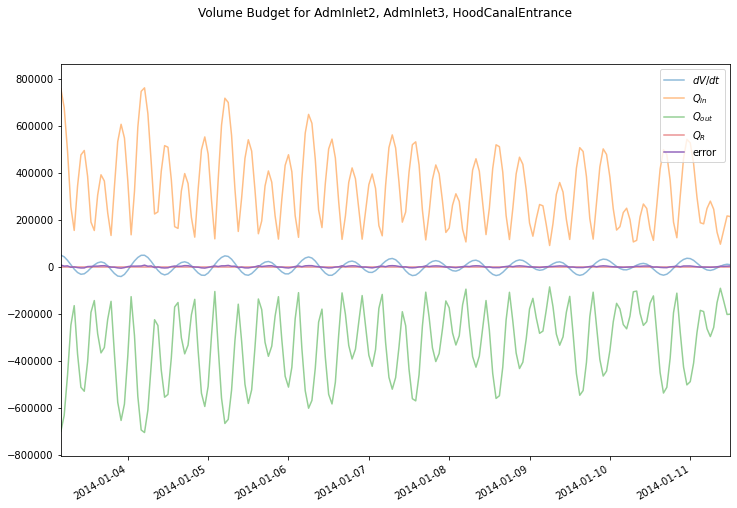

In [19]:
q_in_total = np.sum([q_in[s] for s in section_names], axis=0)
q_out_total = np.sum([q_out[s] for s in section_names], axis=0)
error = (-dVdt + q_in_total + q_out_total + rivers_interp)
fig, ax = plt.subplots(figsize=(12,8))
model_start_date = section_extractions[next(iter(section_names))].date_string0
dates = pd.Timestamp(model_start_date) + pd.to_timedelta(model_output_times[1:], 's')
ax.plot(dates, dVdt, label='$dV/dt$', alpha=0.5)
#for s in section_names:
#    l = ax.plot(dates, q_in[s], '--', label=f'{s} $Q_{{in}}$', alpha=0.5)
#    ax.plot(dates, q_out[s], '-.', color=l[0].get_color(), label=f'{s} $Q_{{out}}$', alpha=0.5)
ax.plot(dates, q_in_total, label='$Q_{in}$', alpha=0.5)
ax.plot(dates, q_out_total, label='$Q_{out}$', alpha=0.5)
ax.plot(dates, rivers_interp, label='$Q_R$', alpha=0.5)
ax.plot(dates, error, label='error')
ax.set(xbound=(dates[50], dates[250]))
ax.legend()
fig.autofmt_xdate()
fig.suptitle(f'Volume Budget for {", ".join(section_names)}')
rmse = np.sqrt((error ** 2).sum())/len(error)
error_per_qr = np.nan if rivers_interp.mean() == 0 else rmse / rivers_interp.mean()
print(f'RMSE: {rmse:.2f} cms ({error_per_qr * 100:.2f}% of mean Q_R)')